# **ECON8502: Methods for Structural Microeconometrics**

## **Assignment 6**

### *Conor Bayliss*

#### **Introduction and Setup**

*Let's return to the simple model of labour supply and programme participation from Assignment 2.*

*Consider the following extension to the model. Suppose that each individual $n$ belongs to one of $K$ finite types, $k(n) \in \{1,2,...,K\}$. Types determine differences in the cost of work and programme participation as well as differences in wages:*
$$
U_{ntj} = \log(\max\{50, Y_{nt}(W_{nt}H_j)\})+\alpha_{l,k}\log(112-H_j)-\alpha_{P,k,1}\mathbf{1}\{P_j>0\}-\alpha_{P,k,2}\mathbf{1}\{P_j>1\}
$$
*and*
$$
\log(W_{nt}) = \gamma_{k,0}+\gamma_{k,1}\text{Age}_{nt}+\gamma_{k,2}\text{Age}^2_{nt}.
$$
*So, the parameters $\alpha_l,\alpha_P,\gamma$ are now **heterogeneous by type**.*

In [2]:
using Clustering, Plots, Statistics, ForwardDiff, LinearAlgebra, Random

In [3]:
using CSV, DataFrames, DataFramesMeta, Optim

In [4]:
include("C:\\Users\\bayle\\Documents\\Github\\micro_labour\\src\\Transfers.jl")

Main.Transfers

In [5]:
data = @chain begin
    CSV.read("C:\\Users\\bayle\\Documents\\Github\\micro_labour\\hw1\\hw1_micro_labour_data\\MainPanelFile.csv",DataFrame,missingstring = "NA")
    #@select :MID :year :wage :hrs :earn :SOI :CPIU :WelfH :FSInd :num_child :age
    @subset :year.>=1985 :year.<=2010
    @transform :AFDC = :WelfH.>0 
    @rename :FS = :FSInd
    @transform :P  = :FS + :AFDC :H = min.(2,round.(Union{Int64, Missing},:hrs / (52*20)))
    @subset .!ismissing.(:P) .&& .!ismissing.(:H)
    @transform @byrow :wage = begin
        if :hrs>0 && :earn>0
            return :earn / :hrs / :CPIU
        else
            return missing
        end
    end
end

data_mle = (;P = Int64.(data.P), H = Int64.(data.H), year = data.year, age = data.age,
            soi = data.SOI, num_kids = data.num_child, cpi = data.CPIU,
            logwage = log.(coalesce.(data.wage,1.)),wage_missing = ismissing.(data.wage))

(P = [2, 2, 2, 1, 0, 0, 0, 2, 1, 0  …  2, 2, 1, 2, 0, 0, 1, 1, 1, 1], H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 2  …  0, 0, 2, 2, 2, 2, 0, 0, 0, 0], year = [1994, 1995, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 1990  …  1991, 1992, 1991, 1992, 1991, 1992, 1991, 1992, 1991, 1992], age = [21, 22, 23, 25, 27, 29, 31, 33, 35, 17  …  21, 22, 23, 24, 39, 40, 30, 31, 25, 26], soi = [43, 43, 43, 43, 43, 43, 43, 43, 43, 17  …  44, 44, 7, 7, 5, 5, 39, 39, 39, 39], num_kids = [2, 2, 3, 3, 3, 3, 3, 3, 3, 1  …  2, 2, 2, 2, 3, 3, 4, 4, 2, 2], cpi = [0.860812349005761, 0.884959812302546, 0.910948243820851, 0.946664188812488, 1.0, 1.04457233785542, 1.09707768072849, 1.17054218546739, 1.25008130459022, 0.758792510685746  …  0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336], logwage = [0.0, 0.0, 0.0, 0.0, 1.2039728043259361, 0.0, 0.0, 0.0, 0.0, 0.8230555833449215  …  0.0, 0.0, 2.651257

#### **Part 1**

*Write a routine to classify individuals in the data into one of $K=3$ types using K-means clustering. You may find the package `Clustering.jl` useful.*

In [6]:
# Aggregate data by 'MID'
agg_data = @chain data begin
    @groupby[:MID]
    @transform mean_P = mean(:P)
    @transform mean_H = mean(:H)
end

collapsed_data = combine(groupby(data, :MID), :P => mean, :H => mean)

# Extract 'mean_P' and 'mean_H' from the aggregated data and convert them to a matrix
X_agg = hcat(collapsed_data.P_mean, collapsed_data.P_mean)'

# Perform k-means clustering
k = 3  # Number of clusters
result_coll = kmeans(X_agg, k)

# Assign the cluster labels to your aggregated data
collapsed_data.cluster = assignments(result_coll)

collapsed_data

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mean_P = ... instead.
└ @ DataFramesMeta C:\Users\bayle\.julia\packages\DataFramesMeta\VSP9g\src\parsing.jl:387
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mean_H = ... instead.
└ @ DataFramesMeta C:\Users\bayle\.julia\packages\DataFramesMeta\VSP9g\src\parsing.jl:387


Row,MID,P_mean,H_mean,cluster
,Int64,Float64,Float64,Int64
1,4031,1.11111,0.0,1
2,4032,0.5,1.0,1
3,4179,0.0625,1.25,2
4,4180,0.25,0.5,2
5,5173,1.0,0.0,1
6,5177,0.0,0.5,2
7,7030,0.4,0.5,2
8,7040,0.0,1.0,2
9,7180,0.666667,1.0,1


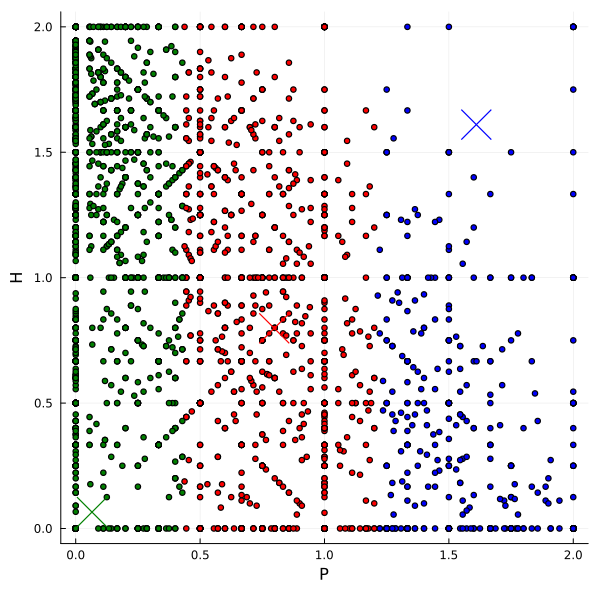

In [7]:
# Create a color map for the clusters
#colors = [:red, :green, :blue, :yellow, :purple, :orange, :cyan, :magenta, :brown]
colors = [:red, :green, :blue]

# Plot the data points with color coding for clusters
ax = scatter(collapsed_data.P_mean, collapsed_data.H_mean, markersize = 3, color = [colors[cluster] for cluster in collapsed_data.cluster], xlabel = "P", ylabel = "H", size = (600,600), legend = false)

# Plot the centroids
for i in 1:size(result_coll.centers, 2)
    scatter!(ax, [result_coll.centers[1, i]], [result_coll.centers[2, i]], markersize = 15, color = colors[i], marker = :x)
end

display(ax)

#### **Part 2**

*Calculate and plot average work and average programme participation over time for each of these types. Comment on what you are seeing.*

In [8]:
clustered_data = innerjoin(data, collapsed_data, on = :MID)

type_means = @chain clustered_data begin
    @groupby(:cluster, :year)
    @combine(mean_H = mean(:H_mean), mean_P = mean(:P_mean))
end

type_means

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mean_H = ... instead.
└ @ DataFramesMeta C:\Users\bayle\.julia\packages\DataFramesMeta\VSP9g\src\parsing.jl:387
┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mean_P = ... instead.
└ @ DataFramesMeta C:\Users\bayle\.julia\packages\DataFramesMeta\VSP9g\src\parsing.jl:387


Row,cluster,year,mean_H,mean_P
,Int64,Int64,Float64,Float64
1,1,1985,0.850985,0.755319
2,1,1986,0.834059,0.75613
3,1,1987,0.825369,0.761103
4,1,1988,0.81761,0.758826
5,1,1989,0.761575,0.759315
6,1,1990,0.738713,0.758662
7,1,1991,0.730257,0.771569
8,1,1992,0.768978,0.774636
9,1,1993,0.841329,0.763132


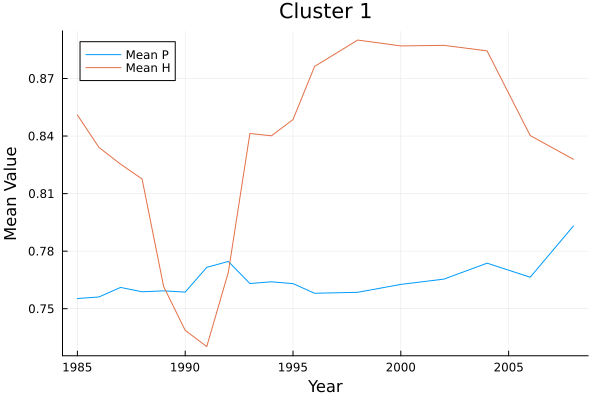

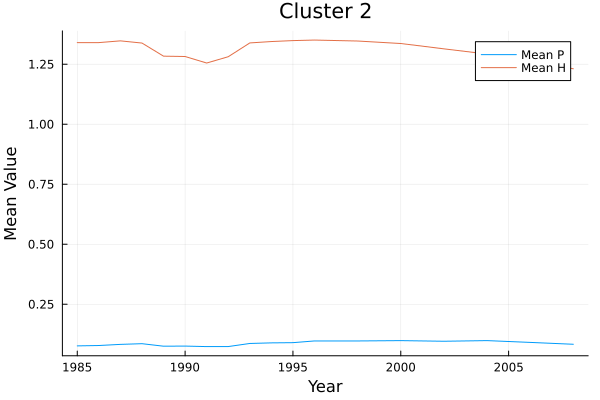

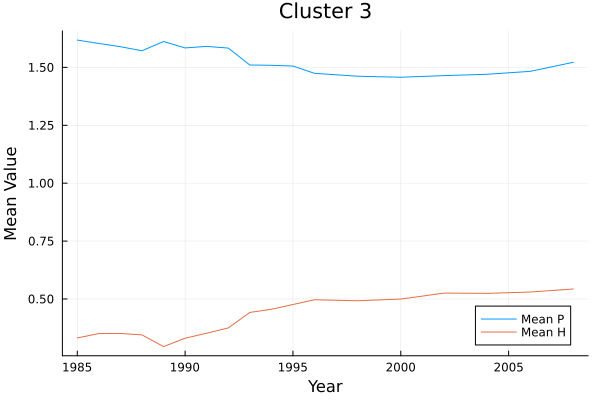

In [9]:
unique_clusters = unique(clustered_data.cluster)

unique_clusters = sort(unique_clusters)

for cluster in unique_clusters
    # Filter the data for the current cluster
    cluster_data = filter(row -> row.cluster == cluster, type_means)
    
    # Create a new plot for the current cluster
    p = plot(cluster_data.year, [cluster_data.mean_P, cluster_data.mean_H], label = ["Mean P" "Mean H"], title = "Cluster $cluster", xlabel = "Year", ylabel = "Mean Value")
    
    # Display the plot
    display(p)
end

#### **Part 3**

*Write code to estimate this extended model. You could just make a small extension to the maximum likelihood estimator you used in Assignment 2, or you could try another approach if your prefer.*

In [10]:
clustered_mle = (;P = Int64.(clustered_data.P), H = Int64.(clustered_data.H), year = clustered_data.year, age = clustered_data.age,
                soi = clustered_data.SOI, num_kids = clustered_data.num_child, cpi = clustered_data.CPIU,
                logwage = log.(coalesce.(clustered_data.wage,1.)),wage_missing = ismissing.(clustered_data.wage),
                cluster = clustered_data.cluster)

(P = [2, 2, 2, 1, 0, 0, 0, 2, 1, 0  …  2, 2, 1, 2, 0, 0, 1, 1, 1, 1], H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 2  …  0, 0, 2, 2, 2, 2, 0, 0, 0, 0], year = [1994, 1995, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 1990  …  1991, 1992, 1991, 1992, 1991, 1992, 1991, 1992, 1991, 1992], age = [21, 22, 23, 25, 27, 29, 31, 33, 35, 17  …  21, 22, 23, 24, 39, 40, 30, 31, 25, 26], soi = [43, 43, 43, 43, 43, 43, 43, 43, 43, 17  …  44, 44, 7, 7, 5, 5, 39, 39, 39, 39], num_kids = [2, 2, 3, 3, 3, 3, 3, 3, 3, 1  …  2, 2, 2, 2, 3, 3, 4, 4, 2, 2], cpi = [0.860812349005761, 0.884959812302546, 0.910948243820851, 0.946664188812488, 1.0, 1.04457233785542, 1.09707768072849, 1.17054218546739, 1.25008130459022, 0.758792510685746  …  0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336, 0.790785866939231, 0.8148346032336], logwage = [0.0, 0.0, 0.0, 0.0, 1.2039728043259361, 0.0, 0.0, 0.0, 0.0, 0.8230555833449215  …  0.0, 0.0, 2.651257

In [11]:
pars_Λ = (;αl = ones(3), 
        σ = 1., 
        σW = 1., 
        γ_1 = zeros(3),
        γ_2 = zeros(3),
        γ_3 = zeros(3),
        Hgrid = [0,20.,40.],
        αP_1 = zeros(2),
        αP_2 = zeros(2),
        αP_3 = zeros(2)) # Initial parameters
        
# Function that calculates utility and index choices 
j_idx(p,h) = p*3 + (h + 1)
function ut(p,h,soi,cpi,year,num_kids,wage,pars_Λ,type)
    (;αl,Hgrid,σ,αP_1, αP_2, αP_3) = pars_Λ
    hrs = Hgrid[1+h]
    earn = wage * hrs
    net_income = max(50.,Transfers.budget(earn,0.,soi,year,num_kids,cpi,p))
    if type == 1
        return log(net_income) + αl[type]*log(112-hrs) - αP_1[1]*(p>0) - αP_1[2]*(p>1)
    elseif type == 2
        return log(net_income) + αl[type]*log(112-hrs) - αP_2[1]*(p>0) - αP_2[2]*(p>1)
    else
        return log(net_income) + αl[type]*log(112-hrs) - αP_3[1]*(p>0) - αP_3[2]*(p>1)
    end
end

ut (generic function with 1 method)

In [12]:
# Choice probabilities are given by the logit formula
function Λ_choice_prob!(logP,it,data,pars_Λ)
    (;σ,γ_1, γ_2, γ_3) = pars_Λ
    type = data.cluster[it]
    if type == 1
        wage = exp(γ_1[1]+γ_1[2]*data.age[it]+γ_1[3]*data.age[it]^2) 
    elseif type == 2
        wage = exp(γ_2[1]+γ_2[2]*data.age[it]+γ_2[3]*data.age[it]^2) 
    else
        wage = exp(γ_3[1]+γ_3[2]*data.age[it]+γ_3[3]*data.age[it]^2) 
    end  
    denom = 0.
    umax = -Inf
    for p in 0:2
        for h in 0:2
            j = j_idx(p,h)
            u = ut(p,h,data.soi[it],data.cpi[it],data.year[it],data.num_kids[it],wage,pars_Λ,type)
            logP[j] = u / σ
            umax = u>umax ? u : umax
        end
    end
    logP[:] .-= umax / σ
    denom = log(sum(exp.(logP)))
    logP[:] .-= denom #<- normalise choice probabilities
end

Λ_choice_prob! (generic function with 1 method)

In [13]:
function Λ_log_likelihood(logP,it,data,pars_Λ)
    (;γ_1, γ_2, γ_3 ,σW) = pars_Λ
    ll = 0.
    type = data.cluster[it]
    if !data.wage_missing[it]
        if type == 1
            ll += -((data.logwage[it] - γ_1[1] - γ_1[2]*data.age[it] - γ_1[3]*data.age[it]^2) / σW)^2 - log(σW)
        elseif type == 2
            ll += -((data.logwage[it] - γ_2[1] - γ_2[2]*data.age[it] - γ_2[3]*data.age[it]^2) / σW)^2 - log(σW)
        else
            ll += -((data.logwage[it] - γ_3[1] - γ_3[2]*data.age[it] - γ_3[3]*data.age[it]^2) / σW)^2 - log(σW)
        end
    end
    Λ_choice_prob!(logP,it,data,pars_Λ)
    j = j_idx(data.P[it],data.H[it])
    ll += logP[j]
    return ll
end

function Λ_update(x,p)
    αl = exp.(x[1:3])
    σ = exp(x[4])
    γ_1 = x[5:7]
    γ_2 = x[8:10]
    γ_3 = x[11:13]
    σW = exp(x[14])
    αP_1 = x[15:16]
    αP_2 = x[17:18]
    αP_3 = x[19:20]
    return (;p...,αl, σ, σW, γ_1, γ_2, γ_3, αP_1, αP_2, αP_3)
end

function Λ_log_likelihood(x,data,pars_Λ)
    pars_Λ = Λ_update(x,pars_Λ)
    logP = zeros(eltype(x),9)
    ll = 0.
    for it in eachindex(data.P)
        ll += Λ_log_likelihood(logP,it,data,pars_Λ)
    end
    return ll
end

Λ_x0 = [0., 0., 0., 0., log(10.), 0., 0., 0., 0., 0., 0., 0., 0., log(10.), 0., 0., 0., 0., 0., 0.]
Λ_res = optimize(x->-Λ_log_likelihood(x,clustered_mle,pars_Λ),Λ_x0,BFGS(),autodiff=:forward,Optim.Options(show_trace = true))
pars = Λ_update(Λ_res.minimizer,pars_Λ)

Iter     Function value   Gradient norm 
     0     1.229400e+05     4.518250e+06
 * time: 0.016000032424926758
     1     1.076425e+05     1.102917e+06
 * time: 2.2809998989105225
     2     1.076403e+05     1.107191e+06
 * time: 3.5810000896453857
     3     1.076300e+05     1.107491e+06
 * time: 4.884000062942505
     4     9.713855e+04     1.995765e+06
 * time: 5.947000026702881
     5     8.468774e+04     4.222552e+06
 * time: 8.058000087738037
     6     7.895403e+04     6.491058e+06
 * time: 10.361999988555908
     7     7.459607e+04     8.640028e+06
 * time: 11.891999959945679
     8     6.440706e+04     8.326072e+06
 * time: 13.99399995803833
     9     6.341682e+04     4.482740e+06
 * time: 14.960999965667725
    10     6.324350e+04     2.639319e+06
 * time: 15.839999914169312
    11     6.291902e+04     3.526887e+06
 * time: 16.96399998664856
    12     6.282115e+04     5.028519e+06
 * time: 18.39400005340576
    13     6.270019e+04     5.195932e+06
 * time: 19.9660000801086

(αl = [4.6621363791275625, 7.98339956811817e-27, 10.553556370890858], σ = 2.0237436257341934, σW = 0.9717777748291682, γ_1 = [0.766717137243711, 0.05661812488836395, -0.0006235253114734707], γ_2 = [0.4181927875819577, 0.09443271983654077, -0.0010963458948854983], γ_3 = [1.1037582745871244, 0.0273774098154209, -0.0002855830505335928], Hgrid = [0.0, 20.0, 40.0], αP_1 = [0.7190820337099203, 2.8891683125510172], αP_2 = [5.94926524584647, 5.049477865886458], αP_3 = [-0.8711756605083744, -0.9865320311636485])